# Assignment 2 -- Deep Learning PhD course @ UU

Author: Paul Zeiger

These are my the solutions to assignment 2. I have decided to write this document in a Jupyter notebook, since this allows me to report in the most natural and reproducible way on my results. 

We start by preparing the playground for this report and import some packages and detect if there is a CUDA device in the machine.

In [6]:
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


I have written some helper functions in external `.py` files which perform various tasks such as data loading (`data_handling.py`), implementing a neural network abstraction class (`my_nn_pytorch.py`) and plotting performance measure (`my_plot_functions.py`). We load them here:

In [7]:
import data_handling as dh
import my_nn_pytorch as mnn
import my_plot_functions as mpf

This assignment is split into two parts: in section 1 we construct a convolutional neural network for the MNIST dataset while, in section 2, we build a convolutional neural network for biomedical image segmentation.

# 1 Classification of hand-written digits using a Convolutional Neural Network

In this part of the assignment we construct a convolutional neural network for the MNIST dataset. The MNIST dataset is a commonly used benchmark dataset in machine learning, particularly for image classification tasks. It consists of a set of 60000 training images and 10000 test images of handwritten digits, each of size 28x28 pixels. The digits are grayscale images, and each image is labeled with the corresponding digit (0-9).

As a first step we therefore load the MNIST dataset. We have written a customised version of the `Dataset()` class in `pytorch` for the MNIST dataset. The `init_MNIST()` function loads the dataset using the custom class and returns two instances of `torch.utils.data.Dataloader()`, one for the training data and one for the test data:

In [4]:
dataloader_train, dataloader_test = dh.init_MNIST(batch_size_train, batch_size_test)

Dataset MNISTDataset
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNISTDataset
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Shape of X for train data [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y for train data:  torch.Size([64]) torch.int64
Shape of X for test data [N, C, H, W]:  torch.Size([1000, 1, 28, 28])
Shape of y for test data:  torch.Size([1000]) torch.int64


Next we define the hyper parameters, which we are going to use in the following. The rational behind the choice of the parameters is the following:
1. `batch_size_train`: we choose it small to avoid overfitting of the data even if it is computationally less efficient
2. `batch_size_test`: we choose it large, since my GPU can handle it and I think that the evaluation should go faster if we run it all at once
3. `lr_sgd`: I have observed that with this learning rate the training goes relatively fast and gives still good final accuracy
4. `nepochs`: After this number of epochs, the training did not improve the results much further.

In [9]:
batch_size_train = 64         # batch size during training
batch_size_test = 1000        # batch size for the test data
lr_sgd = 1e-1                 # learning rate for Stochastic Gradient Descent (SGD)
nepochs = 10                   # number of epochs to run the training

Now the stage is set and we are ready to start buidling our neural networks.

## 1.1 Fully connected neural network

As a first investigation, we establish a baseline by constructing a fully connected neural network with 4 fully connected layers. The network definition reads as follows:

In [25]:
class FullyConnectedMNIST(nn.Module):
    def __init__(self):
        super(FullyConnectedMNIST, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Now we train the network and after the training has commenced, we save the network in a pickle file to disk, so we can run the notebook again without redoing the training. We train the model in the following way:
- loss function: cross entropy loss for classification. The `pytorch` implementation of this function expects raw logits as input (the output of the last fully connected layer without applying a softmax to get class probabilities). The reason is that combining the softmax function and computing the cross entropy loss, as it is done in `CrossEntropyLoss()`, is numerically more stable.
- optimizer: we use plain standard stochastic gradient descent

In [26]:
fname = 'ex11_fc_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = FullyConnectedMNIST()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

FullyConnectedMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.307         0.0986
        0         0      TEST     2.307         0.0958
        1       938     TRAIN     0.242         0.9236
        1       938      TEST     0.233         0.9270
        2      1876     TRAIN     0.165         0.9480
        2      1876      TEST     0.164         0.9485
        3      2814     TRAIN     0.118         0.9631
        3      2814      TEST     0.129         0.9583
        4      3752     TRAIN     0.084         0.9739
        4      3752      TEST     0.106        

We consider now the performance which this fully connected network achieves. By performance we mean here the prediction accuracy and the value of the loss. The figure below shows both performance figures as a function of epoch for the total training data set (blue color) and for the test data (orange color). Additionally the grey data points indicate the performance on the corresponding batch during the training. The accuracy does not improve meaningfully on the test data after 5 epochs, whereas the accuracy on the training data improves all the way up to 10 epochs. A similar observation can be made for the value of the loss. This suggests that after 5 epochs the model starts to be overfitted to the training data and we should probably terminate after 5 epochs if we were to use this model for any real purpose. The accuracy on the test data does not seem to be impacted much by the overfitting, however.

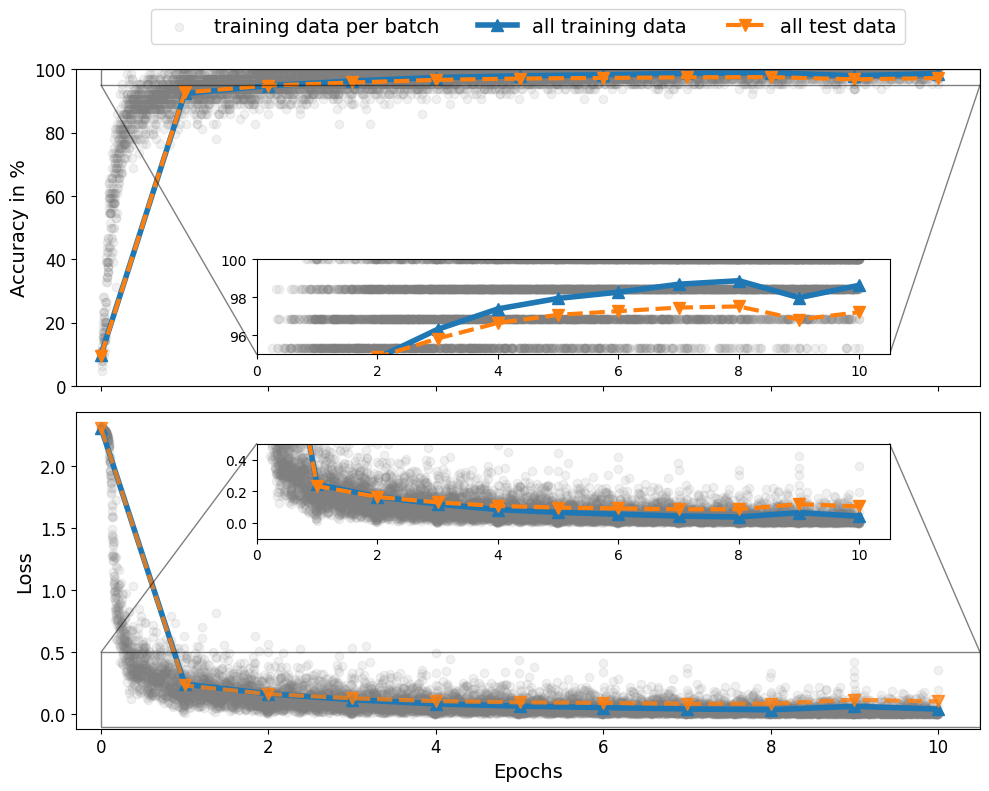

In [27]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final performance of the fully connected model after 10 epochs of training is an accuracy of 97.0% on the test data and the cost is 0.129. The model performs somewhat better on the training data, which suggests some overfitting, similar to the data in the figure above:

In [28]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.104         0.9722
       10      9380     TRAIN     0.042         0.9864


The training of 10 epochs took 180 seconds, that is 3 minutes.

In [29]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 190 s


## 1.2 Convolutional Neural Network

After having established the performance we an get from a fully connected neural network, we turn our attention towards constructiong a convolutional neural network. As a starting point we build the following convolutional neural network:

| Layer | Function              | More detailed description                                | Output size | Number of parameters            |
|-------|-----------------------|----------------------------------------------------------|-------------|---------------------------------|
| 0     | Input                 | 28x28 px grey scale images                               | 1x28x28     | 0                               |
| 1     | Convolution           | 8 times 3x3x1 convolutions with stride 1 and padding 1   | 8x28x28     | (3\*3\*1+1)\*8 = 80      |
| 2     | ReLU                  | Non-linearity                                            | 8x28x28     | 0                               |
| 3     | Max Pooling           | 2x2 max pooling with stride 2                            | 8x14x14     | 0                               |
| 4     | Convolution           | 16 times 3x3x8 convolutions with stride 1 and padding 1  | 16x14x14    | (3\*3\*8+1\*16 = 1168   |
| 5     | ReLU                  | Non-linearity                                            | 16x14x14    | 0                               |
| 6     | Max Pooling           | 2x2 max pooling with stride 2                            | 16x7x7      | 0                               |
| 7     | Convolution           | 32 times 3x3x16 convolutions with stride 1 and padding 1 | 32x7x7      | (3\*3\*16+1\*32 = 4640  |
| 8     | ReLU                  | Non-linearity                                            | 32x7x7      | 0                               |
| 9     | Fully Connected       | 10 fully connected layer                                 | 10          | (32\*7\*7+1)\*10 = 15690 |
| 10    | Softmax               | Softmax layer                                            | 10          | 0                               |
| 11    | Classification Output | Crossentropy with 10 classes                             | 1           | 0                               |

Let's consider the number of learnable parameters of the convolutional and fully connected layers. This number can be computed as follows:
1. For a 3x3 convolution with stride 1 and padding 1 the lateral size of the images does not change. A single 3x3 convolution has 3\*3+1 learnable parameters (the weights of each pixel plus an additional bias). If we carry out $m$ of those in one layer, the number of weights becomes (3\*3+1)\*$m$. And if the input data to the layer was of dimension $l$ images, the number of parameters becomes (3\*3*$l$+1)\*$m$. This is the formula we have used to compute the number of learnable parameters.
2. A fully connected layer has ($n$+1)\*$m$ weights, where $n$ is the number of inputs and $m$ the number of outputs.

Adding the number of learnable parameters in the table, we find for the convolutional neural network we have built here a total of 

80 + 1168 + 4640 + 15690 = 21578

learnable parameters. This is in contrast to the total number of weights in our fully connected network:

(28\*28+1)\*100 + (100+1)\*100 + (100+1)\*100 + (100+1)\*10 = 99710

We see that the convolutional network has only about one fifth of the number of parameters of the fully connected network.

We will now set up the neural network as descirbed in the table above. As we have mentioned before the `CrossEntropyLoss()` in `pytorch` expects the raw logits as input, not class probabilities. Therefore our network definition reads:

In [19]:
class ConvNeuralNetworkMNIST(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNIST, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [41]:
fname = 'ex12_convnn_%iepochs_lr%.4f_bs%i.pkl' % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNIST()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNIST(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.301         0.0567
        0         0      TEST     2.301         0.0575
        1       938     TRAIN     0.114         0.9625
        1       938      TEST     0.104         0.9642
        2      1876     TRAIN     0.065         0.9790
        2      1876      TEST     0.060         0.9792
        3 

Here we plot the performance data of the convolutional network. We see that it reaches about 98% accuracy after about 2 epochs. This is a much better result than we obtained for the fully connected model. Furthermore after about 5-7 epochs the accuracy on the test data does not increase substantially, while the accuracy on the test data continues to increase. This suggests that beyond 7 epochs we start to overfit the the model to the training data. The accuracy on the test data does not seem to be impacted much by the overfitting, however.

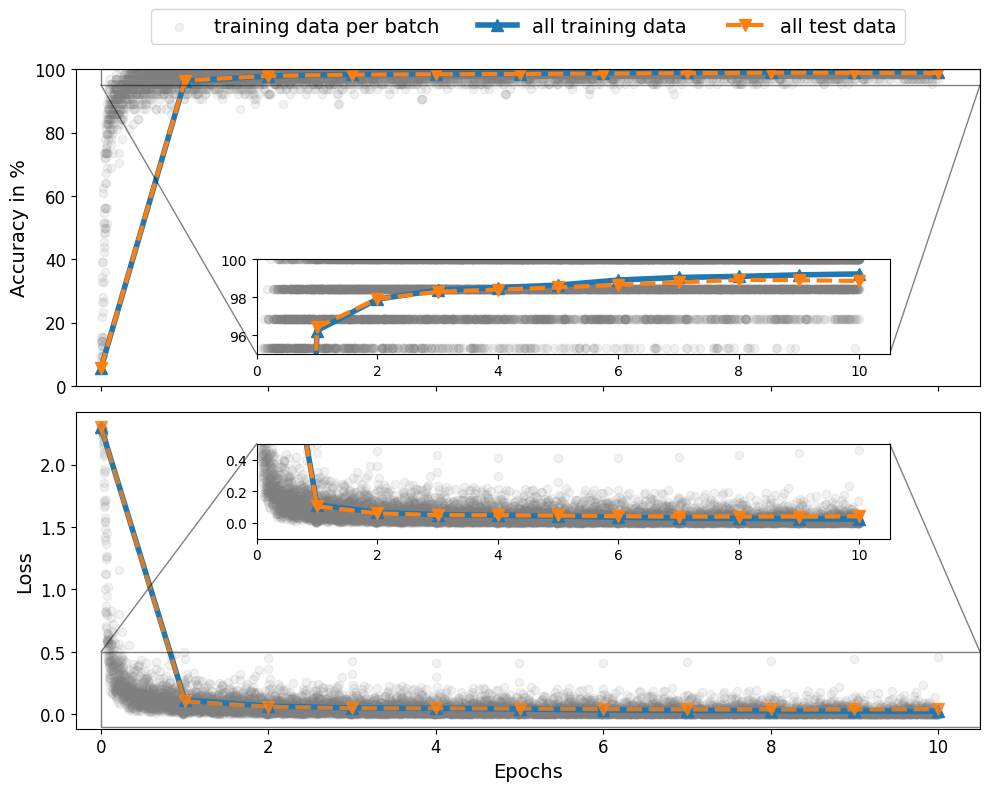

In [42]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network on the test data after 10 epochs is 98.6 % with a value of the cost function of 0.046. Thus the convolutional network performs significantly better than the fully connected model after 10 epochs of training. Also we observe a smaller discrepancy between the performance on the test data and the performance on the training data, suggesting that the model is more robust against overfitting.

In [43]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.041         0.9886
       10      9380     TRAIN     0.024         0.9923


The total training time of the convolutional model was about 243 seconds, i.e., 4 minutes and 3 seconds. The training took thus a bit longer than for the fully connected model. At first glance the result is a bit surprising, since we have fewer parameters to optimize, but each of the mathematical operations is more complex than the simple linear transformations in the fully connected model and we have many more layers, so it is probably not unreasonable.

In [44]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 243 s


## 1.3 Convolutional Neural Network with swapped order of activation function and Max pooling

We now investigate what happens if we change the order of the activation function and the max pooling operation. In section 1.3.1 we do this for the ReLU activation, which is a fast to evaluate non-linearity, which performs well in machine learning applications. In section 1.3.2 we will switch over to a Tanh activation function and then consider the effect of swapping activation and maxppoling also for this case in section 1.3.3.

### 1.3.1 Swapping the order of ReLU and max pooling

We start by changing the order of activation and maxpooling in our convolutional network:

In [31]:
class ConvNeuralNetworkMNISTSwap(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTSwap, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

The training is then straightforward and similar to what we have done before.

In [40]:
fname = 'ex131_convnn_swaporder_relu_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNISTSwap(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.303         0.0986
        0         0      TEST     2.303         0.0958
        1       938     TRAIN     0.104         0.9662
        1       938      TEST     0.094         0.9681
        2      1876     TRAIN     0.068         0.9782
        2      1876      TEST     0.063         0.9786
      

Here we plot the performance data of the convolutional network. We see that the performance metrics are not impacted by swapping the order of the activation and the maxpooling.

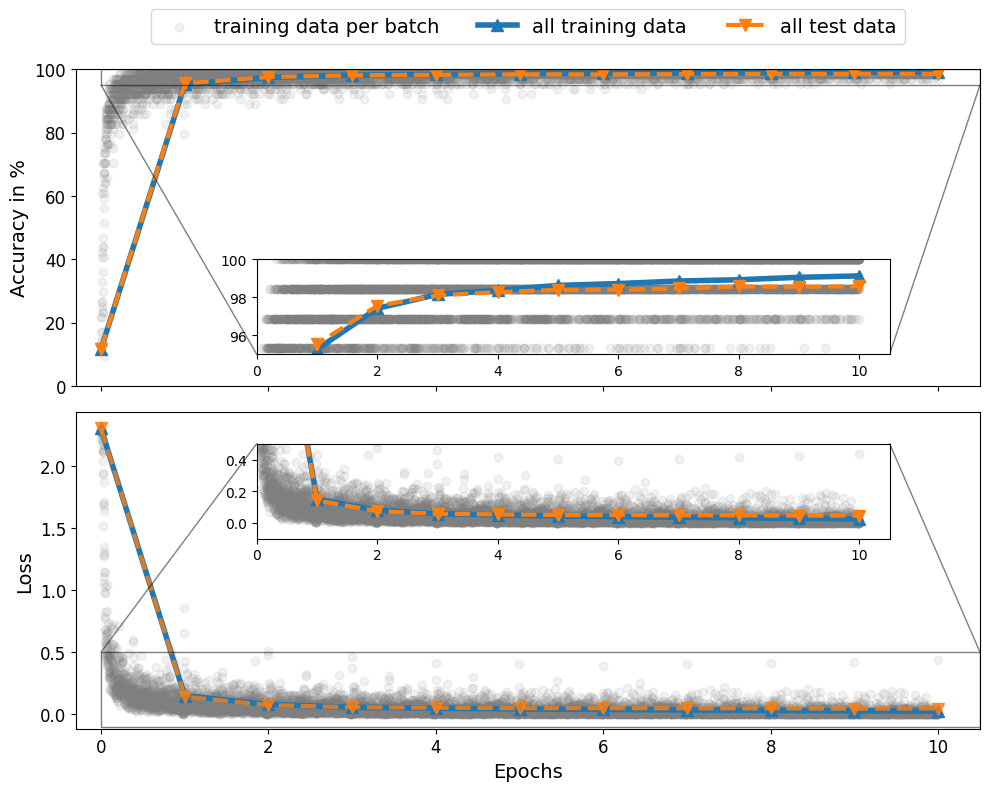

In [35]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

Also the final accuracy of our convolutional network on the test data after 10 epochs is 98.6 % with a value of the cost function of 0.046. Thus the performace after swapping the order of ReLU activation and max pooling is the same as before.

In [36]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.046         0.9858
       10      9380     TRAIN     0.025         0.9913


The total train time is about 220 s, that is 23 s faster than before swapping the order. This can be explained by the fact, that if we apply the activation after maxpooling it is applied to a smaller number of parameters, which means fewer function calls.

In [37]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 220 s


### 1.3.2 Building a convolutional neural network with tanh activation

Here we build a convolutional network with tanh activation function and train it with the usual parameters.

In [47]:
class ConvNeuralNetworkMNISTTanh(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTTanh, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [49]:
fname = 'ex132_convnn_tanh_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTTanh()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNISTTanh(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.303         0.0806
        0         0      TEST     2.303         0.0811
        1       938     TRAIN     0.137         0.9567
        1       938      TEST     0.125         0.9596
        2      1876     TRAIN     0.084         0.9731
        2      1876      TEST     0.077         0.9744
      

Judging from the Figure below the performance metrics are not impacted by the switch of the activation function.

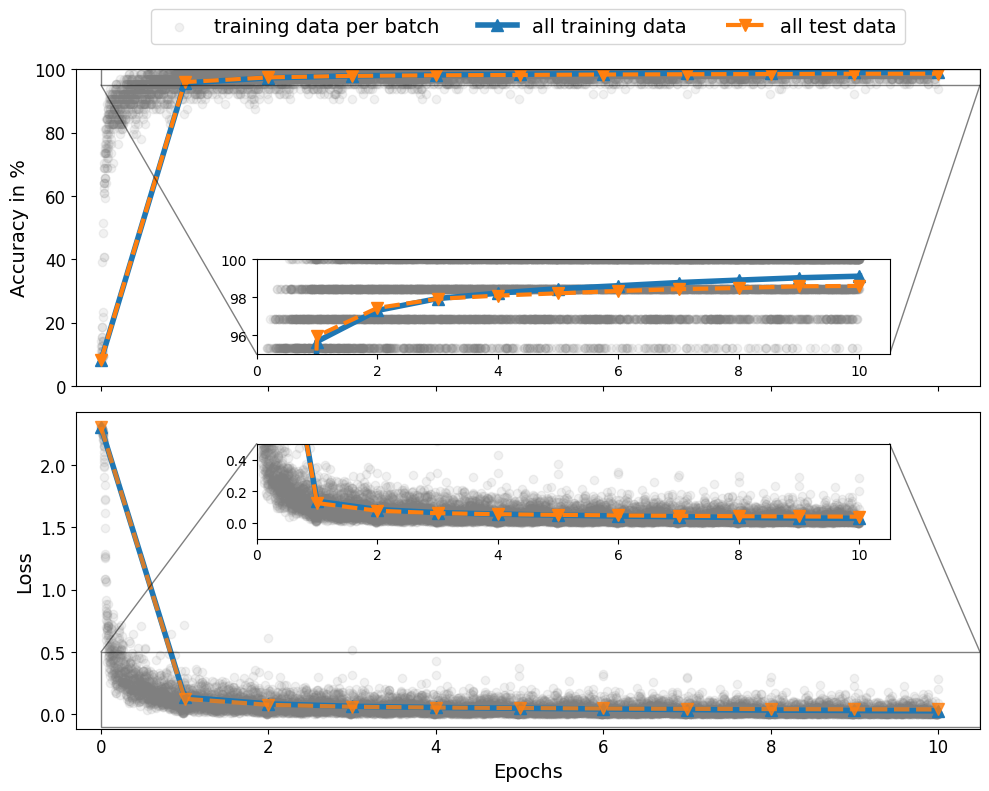

In [50]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network with Tanh activation is 98.6 % with a value of the cost function of 0.039 on the test data after 10 epochs. Thus the performace is similar to the network with the ReLU activation.

In [51]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.039         0.9860
       10      9380     TRAIN     0.028         0.9911


Surprisingly, the convolutional network with Tanh activation took less time to train than the one with ReLU. This seems strange, since the Tanh activation function is more costly to compute than the ReLU activation and should thus lead to longer run time. Maybe we have here a measuring error or I have loaded the computer in some otehr way during the training of the network making use of the ReLU activation.

In [52]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 227 s


### 1.3.3 Swapping the order of tanh activation and max pooling

We now repeat the swapping procedure for the tanh activation function. The resulting network is trained using the usual hyper parameters:

In [53]:
class ConvNeuralNetworkMNISTTanhSwap(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTTanhSwap, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [55]:
fname = 'ex133_convnn_swaporder_tanh_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTTanhSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNISTTanhSwap(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.312         0.0745
        0         0      TEST     2.313         0.0731
        1       938     TRAIN     0.131         0.9596
        1       938      TEST     0.118         0.9633
        2      1876     TRAIN     0.082         0.9740
        2      1876      TEST     0.075         0.9758
  

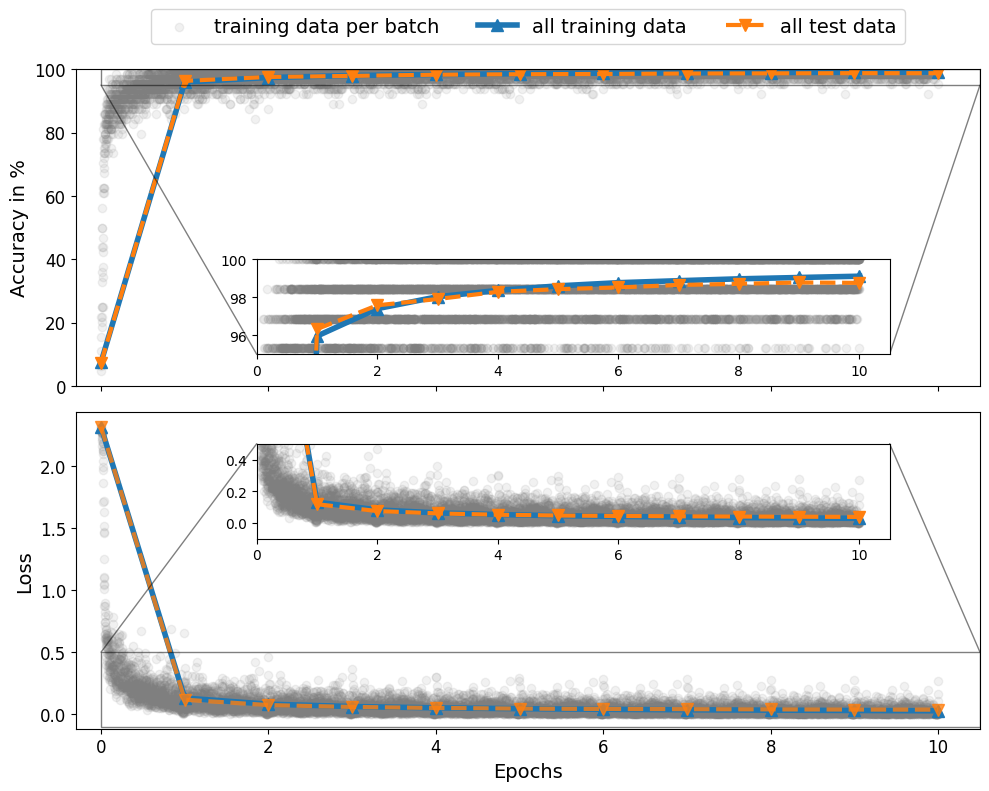

In [56]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

In [57]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.038         0.9876
       10      9380     TRAIN     0.029         0.9911


In [58]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 217 s


### 1.3.4 Summary on the effect of swapping the order of activation function and max pooling

Our results here show, that the performance of the model is unchanged by swapping the order of max pooling and the activation function. However, the time it takes to train the model is affected by the order. Having the activation before the max pooling operation results in a longer training time. This can be explained by the fact, that if the max pooling is performed first, the activation function is applied to a smaller amount of data points. Conversely, max pooling is in both cases performed on the same amount of data points, so there is not speed up associated with swapping the order.

## 1.4 Speeding up the training process with the Adam optimizer

We now use the Adam optimizer instead of the plain SGD algorithm in an attempt to shorten the required training time. 

### 1.4.1 Naive swap of optimizer

We try to just swap out the SGD optimizer for the Adam optimizer and keep all other parameters at their previous values:

In [61]:
fname = 'ex141_convnn_swaporder_relu_adam_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNISTSwap(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.304         0.0929
        0         0      TEST     2.304         0.0948
        1       938     TRAIN     2.304         0.1044
        1       938      TEST     2.304         0.1028
        2      1876     TRAIN     2.304         0.1044
        2      1876      TEST     2.304         0.1028
      

We see that the parameters of the Adam optimizer are at their default values:
- Gradient Decay Factor (β1): 0.9000
- Squared Gradient Decay Factor (β2): 0.9990
- $\epsilon$: $10^{-8}$

In [63]:
print(mynn.optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)


In the Figure below we plot the performance data for using the Adam optimizer. The training is not successful, since the accuracy does not improve and the loss does not decrease. This suggests that we maybe need to doe more than only swapping out the optimizer. A reasonable first guess is, that we could try to reduce the learning rate which we will do in the following section.

(-0.1, 3.0)

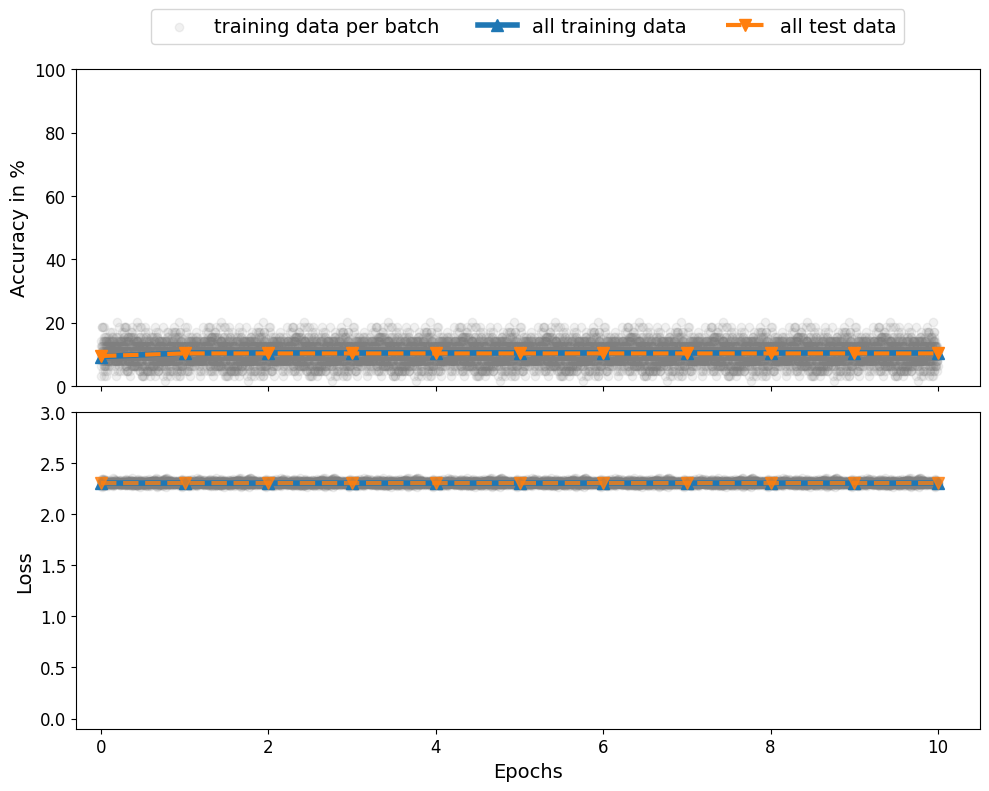

In [70]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train), axins_on=False)
axs[1].set_ylim(bottom=-0.1,top=3)

### 1.4.2 Adapting the learning rate

We saw in the previous section that naively swapping the optimizer resulted in a failed training and we suggested that a next step could be to reduce the learning rate. This is what we do here:

In [71]:
lr_adam = 1e-2

Other than that the training is the same as before:

In [72]:
fname = 'ex142_convnn_swaporder_relu_adam_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

ConvNeuralNetworkMNISTSwap(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
    EPOCH ITERATION   DATASET      COST       ACCURACY
        0         0     TRAIN     2.301         0.1438
        0         0      TEST     2.300         0.1479
        1       938     TRAIN     0.098         0.9704
        1       938      TEST     0.097         0.9712
        2      1876     TRAIN     0.071         0.9800
        2      1876      TEST     0.072         0.9789
      

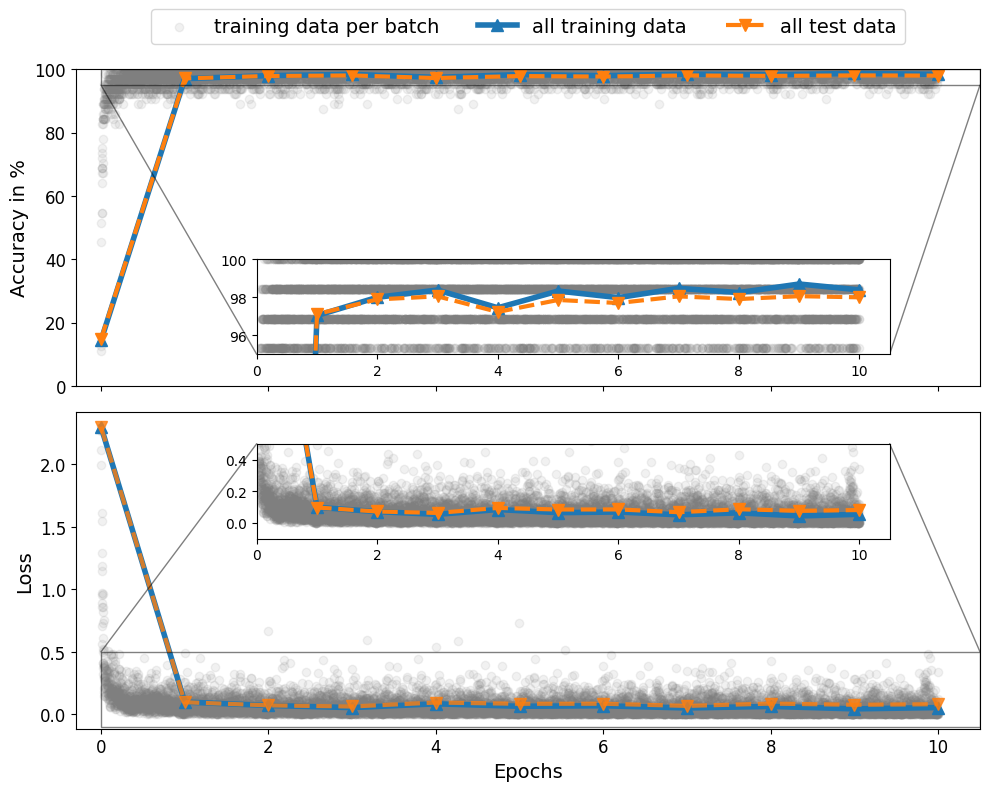

In [73]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_performance(dataset=['test', 'train'], header=True)

Now we compare to the case where we have a smaller learning rate in the SGD algorithm:

In [ ]:
fname = 'ex142_convnn_swaporder_relu_sgd_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

In [ ]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_performance(dataset=['test', 'train'], header=True)

## 1.5 Improving the model

### 1.5.1 Dropout

### 1.5.2 Batch normalization

### 1.5.3 

### 1.5.4 The best model -- confusion matrix and examples

---
---

# 2 Semantic segmentation of Biomedical images

In [68]:
batch_size_train_ww = 8          # batch size during training
batch_size_test_ww = 32          # batch size for the test data
lr_adam_ww = 3e-3                # learning rate for Stochastic Gradient Descent (SGD)
nepochs_ww = 100                 # number of epochs to run the training

We need to load the data with 2 channels, so We define here a custom transform, which we can apply to our dataset.

In [4]:
class LogitsToProbabilitiesImageSegmentation():
    
    def __init__(self):
        self.softmax = nn.Softmax2d()
    
    def __call__(self, logits):
        return self.softmax(logits)


In [5]:
class SorensenDiceCriterion():

    def __init__(self):
        self.name = "dsc"
        self.onehot = mnn.OneHotEncoding()

    def __call__(self, logits, target, full=False):
        a = self.onehot(logits).bool()
        b = target.bool()
        intersect = torch.logical_and(a,b)
        dice_coeff = (2.0 * intersect.sum(dim=(-1,-2))) / (a.sum(dim=(-1,-2)) + b.sum(dim=(-1,-2)))
        return [dice_coeff.cpu().numpy()]

In [40]:
class ImgToTensor2Channels():
    def __init__(self, transform=transforms.ToTensor()):
        self.transform = transform

    def __call__(self, img):
        img = self.transform(img)
        return img[:2,...]


class TargetTransformCrossEntropy():
    def __call__(self, target):
        tmparr = np.array(target)  # Needs to have shape HxW
        return torch.as_tensor(tmparr.astype(np.double)/255., dtype=torch.int64)

In [165]:
training_data = dh.WarwickDataset('WARWICK/Train', transform=ImgToTensor2Channels(),
                                  target_transform=TargetTransformCrossEntropy())

test_data = dh.WarwickDataset('WARWICK/Test', transform=ImgToTensor2Channels(),
                              target_transform=TargetTransformCrossEntropy())

dataloader_train_ww = DataLoader(training_data, batch_size=batch_size_train_ww, shuffle=True)
dataloader_test_ww = DataLoader(test_data, batch_size=batch_size_test_ww, shuffle=True)

loading
loading


## 2.1 Designing a network for semantic segmentation

In [56]:
class NeuralNetworkWarwick(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwick, self).__init__()
        self.nn_stack = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
        )
    
    def forward(self, x):
        logits = self.nn_stack(x)
        return logits

In [69]:
fname = 'ex21_convnn_warwick_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwick()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

NeuralNetworkWarwick(
  (nn_stack): Sequential(
    (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (14): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)
    EPOCH ITERATION 

       66       726     TRAIN     0.213         0.9055
       66       726      TEST     0.512         0.8001
       67       737     TRAIN     0.214         0.9032
       67       737      TEST     0.499         0.7936
       68       748     TRAIN     0.234         0.8976
       68       748      TEST     0.629         0.7852
       69       759     TRAIN     0.228         0.8953
       69       759      TEST     0.468         0.7898
       70       770     TRAIN     0.274         0.8715
       70       770      TEST     0.501         0.7980
       71       781     TRAIN     0.215         0.9040
       71       781      TEST     0.471         0.8037
       72       792     TRAIN     0.220         0.9057
       72       792      TEST     0.541         0.7969
       73       803     TRAIN     0.226         0.9041
       73       803      TEST     0.505         0.7941
       74       814     TRAIN     0.229         0.8975
       74       814      TEST     0.445         0.8055
       75 

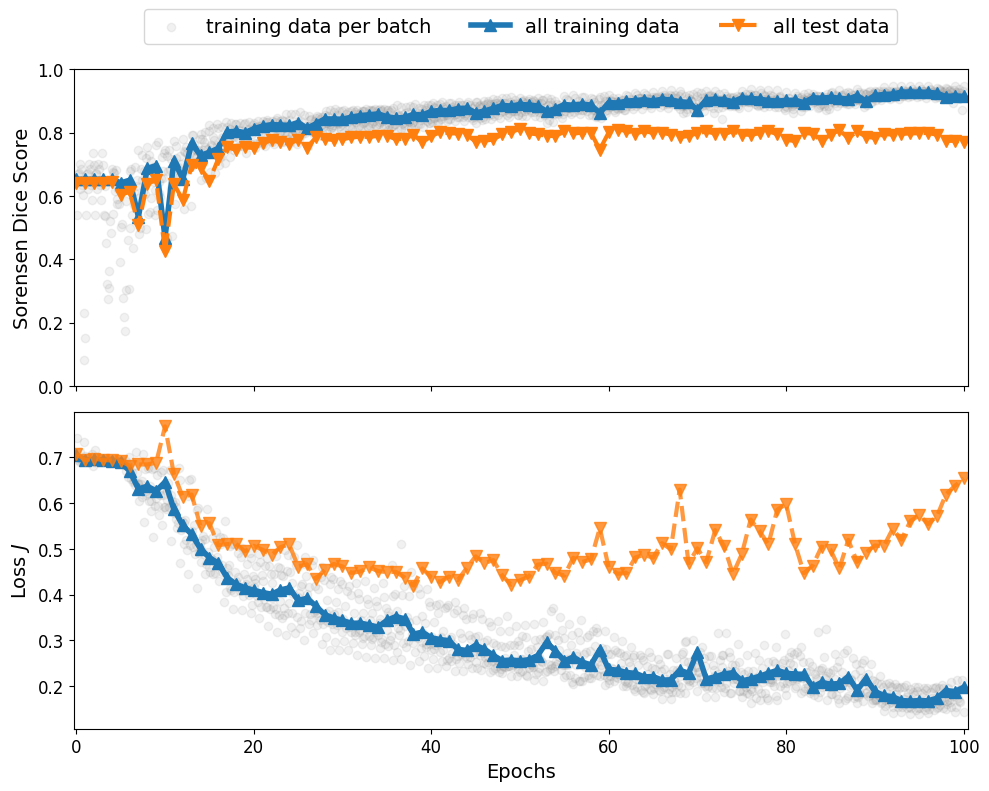

In [70]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

### 2.1.2 Inspecting the predicted maps

We will now visually inspect some of the predicted maps and compare them to the ground truth given by the label mask. 

In [71]:
df = mynn.log2pandas()
crit = df[df.dataset == 'test'].criterion.iloc[-1]
idx = np.argsort(crit)
crit = crit[idx]
X = [dataloader_test_ww.dataset[i][0] for i in idx]
y = [dataloader_test_ww.dataset[i][1] for i in idx]

We take a look at the prediction corresponding to the last, the 20th and first index of our new arrays. These indices correspond to 

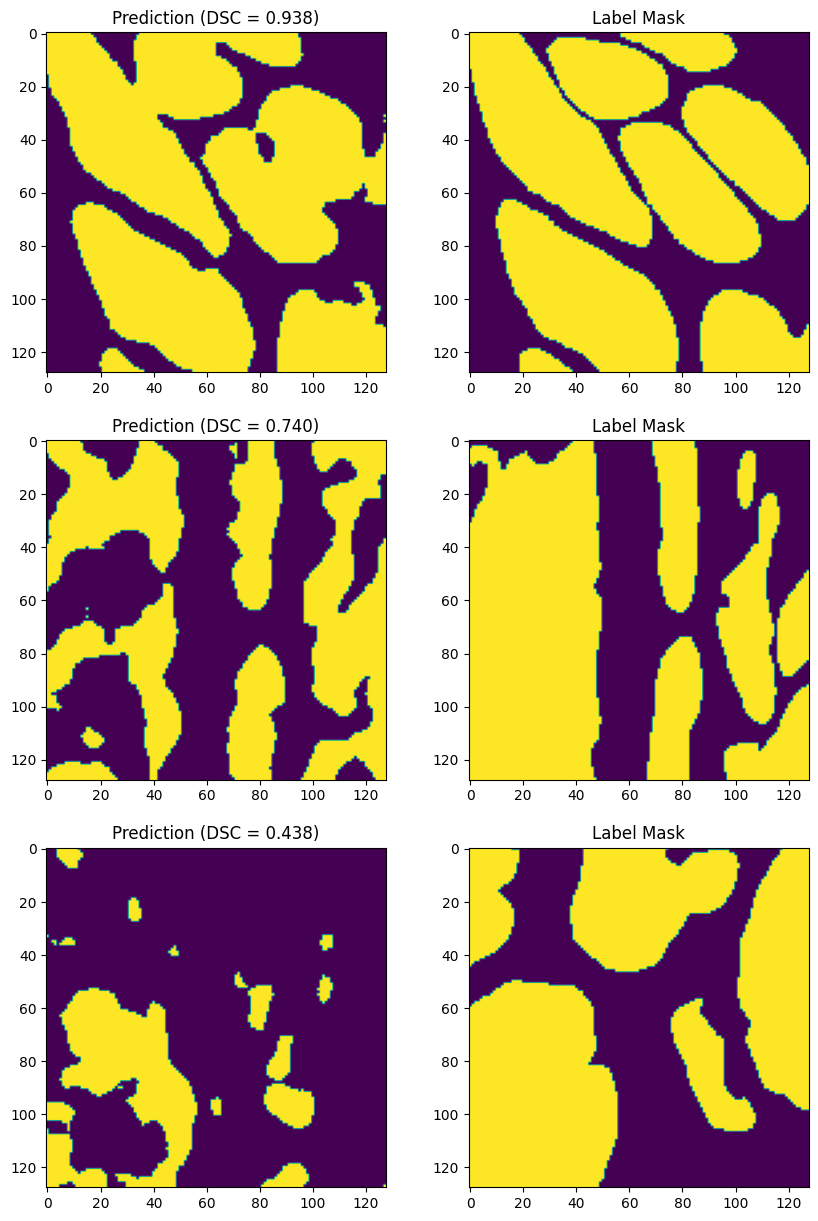

In [72]:
index = -1

fig, axs = plt.subplots(3, 2, figsize=(10,15))

for ii, index in enumerate((-1, 20, 0)):
    onehot_pred = mynn.predict_onehot(X[index][None, :, :, :])
    
    axs[ii,0].set_title('Prediction (DSC = %.3f)' % crit[index])
    axs[ii,0].imshow(onehot_pred.cpu().reshape(128, 128))
    axs[ii,1].set_title('Label Mask')
    axs[ii,1].imshow(y[index])

It seems that the network is doing pretty well on data, which has "stripey" or elongated glands in some part of the image, but it struggles with more round-ish shapes and if there are features all over the image. Furthermore it does not capture very fine separations between glands well.

## 2.2 Improve the network performance on unseen data

In [156]:
class NeuralNetworkWarwickBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwickBatchNorm, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(8)
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        x = self.downconv_0(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_1(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_2(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_3(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.upconv_0(x)
        x = self.bn5(x)
        x = self.upconv_1(x)
        x = self.bn6(x)
        x = self.upconv_2(x)
        x = self.bn7(x)
        logits = self.output(x)        
        return logits


In [162]:
lr_adam_ww_batchnorm = 1e-2

In [168]:
fname = 'ex21_convnn_warwick_batchnorm_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww_batchnorm, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickBatchNorm()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_batchnorm)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

NeuralNetworkWarwickBatchNorm(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (downconv_0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv_0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

       62       682     TRAIN     0.120         0.9478
       62       682      TEST     0.585         0.7989
       63       693     TRAIN     0.114         0.9497
       63       693      TEST     0.480         0.8228
       64       704     TRAIN     0.127         0.9493
       64       704      TEST     0.533         0.8160
       65       715     TRAIN     0.093         0.9606
       65       715      TEST     0.524         0.8128
       66       726     TRAIN     0.098         0.9578
       66       726      TEST     0.531         0.8228
       67       737     TRAIN     0.141         0.9372
       67       737      TEST     0.725         0.7695
       68       748     TRAIN     0.157         0.9307
       68       748      TEST     0.659         0.7981
       69       759     TRAIN     0.096         0.9580
       69       759      TEST     0.650         0.7954
       70       770     TRAIN     0.110         0.9540
       70       770      TEST     0.650         0.8070
       71 

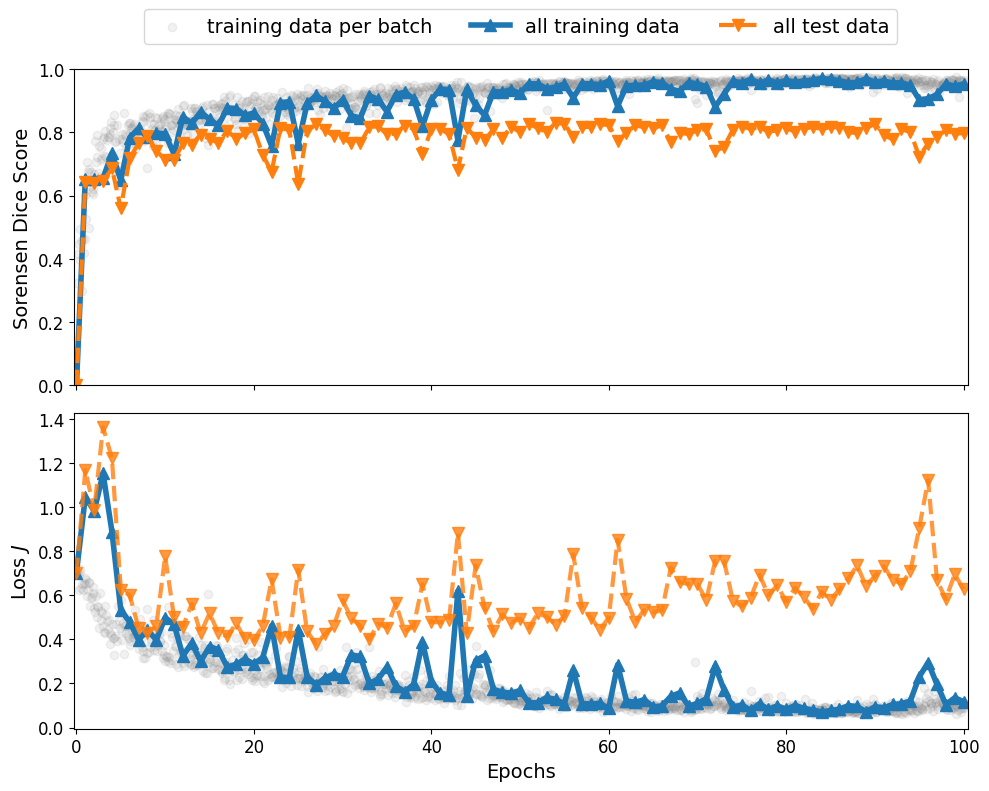

In [169]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

### 2.2.1 Dropout

In [59]:
class NeuralNetworkWarwickDropout(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwickDropout, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        x = self.downconv_0(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_3(x)
        x = self.relu(x)
        x = self.upconv_0(x)
        x = self.upconv_1(x)
        x = self.upconv_2(x)
        logits = self.output(x)        
        return logits


In [60]:
lr_ww_dropout = 3e-3
nepochs_ww_dropout = 200
fname = 'ex21_convnn_warwick_dropout_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_ww_dropout, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropout()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_ww_dropout)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww_dropout)
    mynn.to_disk(fname)

NeuralNetworkWarwickDropout(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (downconv_0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downconv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downconv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downconv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv_0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv_1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv_2): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
)
    EPOCH ITERATION   DATASET      COST            DSC
        0         0     TRAIN     0.719         0.0000
        0         0      TEST     0.715         

       67       737     TRAIN     0.571         0.6405
       67       737      TEST     0.728         0.6039
       68       748     TRAIN     0.623         0.5915
       68       748      TEST     0.758         0.5678
       69       759     TRAIN     0.587         0.6351
       69       759      TEST     0.712         0.6146
       70       770     TRAIN     0.712         0.5473
       70       770      TEST     0.849         0.5253
       71       781     TRAIN     0.578         0.6088
       71       781      TEST     0.693         0.5814
       72       792     TRAIN     0.701         0.5349
       72       792      TEST     0.815         0.5120
       73       803     TRAIN     0.768         0.5189
       73       803      TEST     0.906         0.5074
       74       814     TRAIN     0.582         0.6400
       74       814      TEST     0.711         0.6187
       75       825     TRAIN     0.582         0.6181
       75       825      TEST     0.728         0.5850
       76 

      142      1562     TRAIN     0.637         0.6666
      142      1562      TEST     0.849         0.6450
      143      1573     TRAIN     0.476         0.7237
      143      1573      TEST     0.696         0.6492
      144      1584     TRAIN     0.575         0.6775
      144      1584      TEST     0.763         0.6476
      145      1595     TRAIN     0.568         0.6817
      145      1595      TEST     0.734         0.6453
      146      1606     TRAIN     0.667         0.6322
      146      1606      TEST     0.857         0.6094
      147      1617     TRAIN     0.510         0.7026
      147      1617      TEST     0.689         0.6482
      148      1628     TRAIN     0.488         0.7329
      148      1628      TEST     0.718         0.6606
      149      1639     TRAIN     0.632         0.6444
      149      1639      TEST     0.787         0.6372
      150      1650     TRAIN     0.531         0.6934
      150      1650      TEST     0.754         0.6334
      151 

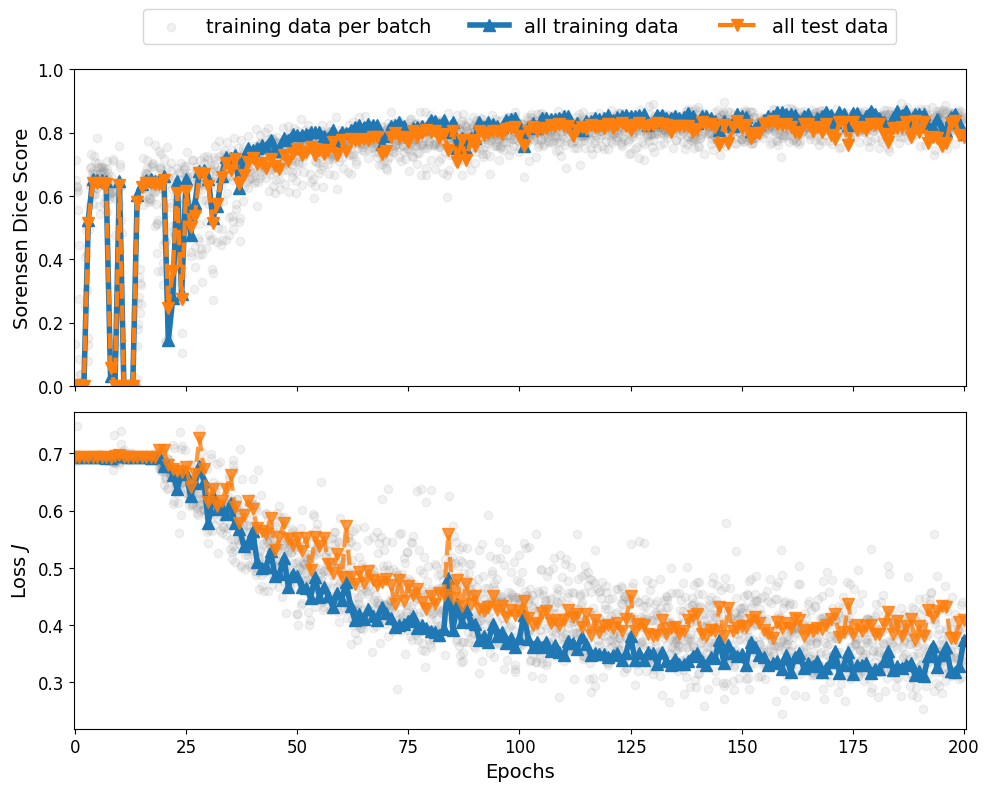

In [29]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

In [30]:
df = mynn.log2pandas()
crit = df[df.dataset == 'test'].criterion.iloc[-1]
idx = np.argsort(crit)
crit = crit[idx]
X = [dataloader_test_ww.dataset[i][0] for i in idx]
y = [dataloader_test_ww.dataset[i][1] for i in idx]

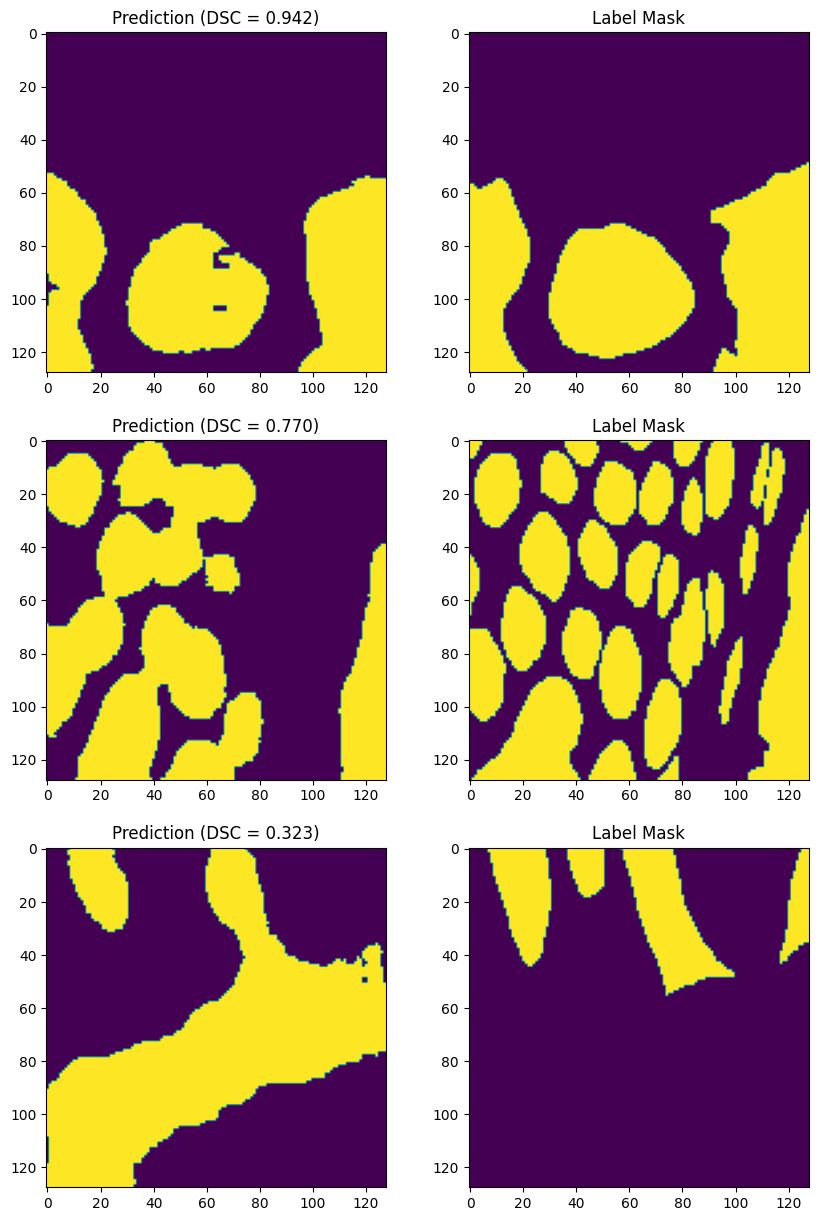

In [31]:
index = -1

fig, axs = plt.subplots(3, 2, figsize=(10,15))

for ii, index in enumerate((-1, 20, 0)):
    onehot_pred = mynn.predict_onehot(X[index][None, :, :, :])
    
    axs[ii,0].set_title('Prediction (DSC = %.3f)' % crit[index])
    axs[ii,0].imshow(onehot_pred.cpu().reshape(128, 128))
    axs[ii,1].set_title('Label Mask')
    axs[ii,1].imshow(y[index])

### 2.2.1.2 Dropout and batch normalisation

In [170]:
class NeuralNetworkWarwickDropoutBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwickDropoutBatchNorm, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(8)
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        x = self.downconv_0(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_1(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_2(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_3(x)
        x = self.bn4(x)
        x = self.upconv_0(x)
        x = self.bn5(x)
        x = self.upconv_1(x)
        x = self.bn6(x)
        x = self.upconv_2(x)
        x = self.bn7(x)
        logits = self.output(x)        
        return logits


In [173]:
lr_adam_ww_dropout_batchnorm = 5e-3

In [174]:
fname = 'ex21_convnn_warwick_dropout_batchnorm_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww_dropout_batchnorm, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropoutBatchNorm()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_dropout_batchnorm)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

NeuralNetworkWarwickDropoutBatchNorm(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (downconv_0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv_0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-0

       61       671     TRAIN     0.429         0.8250
       61       671      TEST     0.489         0.7798
       62       682     TRAIN     0.400         0.8322
       62       682      TEST     0.440         0.7947
       63       693     TRAIN     0.422         0.8300
       63       693      TEST     0.468         0.7967
       64       704     TRAIN     0.502         0.7889
       64       704      TEST     0.547         0.7546
       65       715     TRAIN     0.494         0.7966
       65       715      TEST     0.551         0.7561
       66       726     TRAIN     0.496         0.7870
       66       726      TEST     0.547         0.7471
       67       737     TRAIN     0.387         0.8092
       67       737      TEST     0.420         0.7877
       68       748     TRAIN     0.551         0.7698
       68       748      TEST     0.587         0.7334
       69       759     TRAIN     0.382         0.8204
       69       759      TEST     0.414         0.8089
       70 

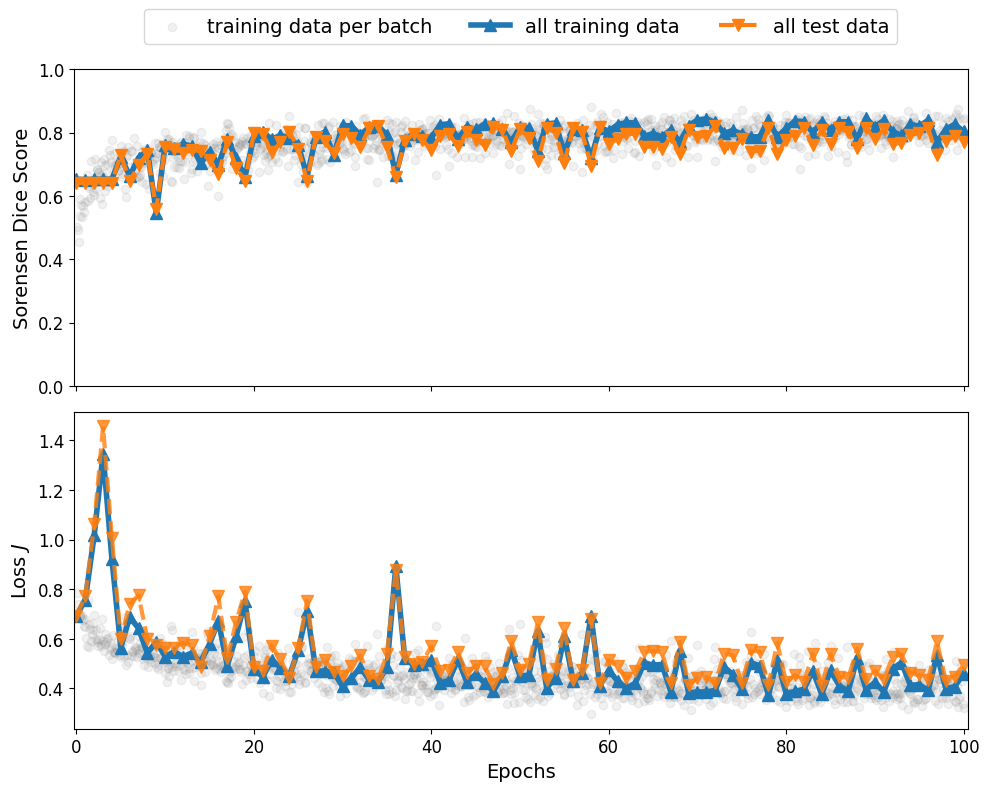

In [175]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

### 2.2.2 Weight decay

In [176]:
weight_decay_ww = 0.0001

In [177]:
fname = 'ex21_convnn_warwick_dropout_wd%.1e_%iepochs_lr%.4f_bs%i.pkl'% (weight_decay_ww, nepochs_ww, lr_adam_ww_batchnorm, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickBatchNorm()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_batchnorm, weight_decay=weight_decay_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

NeuralNetworkWarwickBatchNorm(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (downconv_0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv_0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

       62       682     TRAIN     0.103         0.9544
       62       682      TEST     0.546         0.8107
       63       693     TRAIN     0.090         0.9628
       63       693      TEST     0.553         0.8064
       64       704     TRAIN     0.137         0.9426
       64       704      TEST     0.574         0.8056
       65       715     TRAIN     0.099         0.9596
       65       715      TEST     0.533         0.8176
       66       726     TRAIN     0.082         0.9655
       66       726      TEST     0.529         0.8139
       67       737     TRAIN     0.133         0.9479
       67       737      TEST     0.631         0.7965
       68       748     TRAIN     0.202         0.9092
       68       748      TEST     0.646         0.7906
       69       759     TRAIN     0.128         0.9467
       69       759      TEST     0.608         0.8134
       70       770     TRAIN     0.340         0.8659
       70       770      TEST     0.829         0.7408
       71 

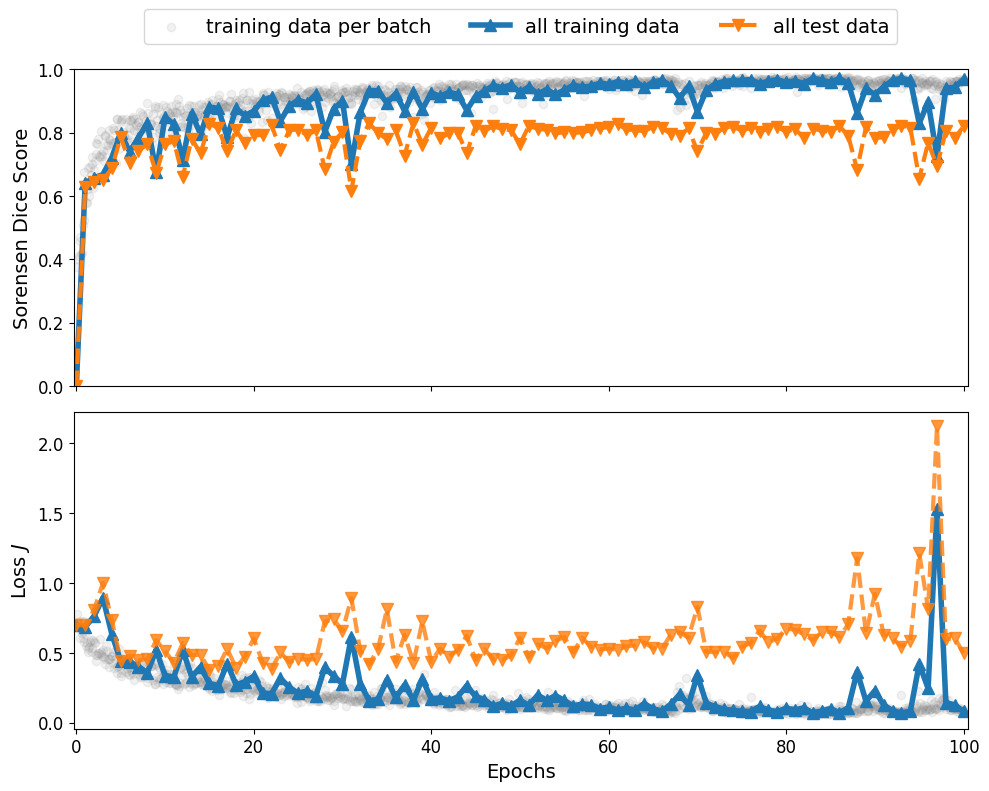

In [179]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

### 2.2.3 Augmenting the data

In [180]:
batch_size_train_ww_augmented = 16
batch_size_test_ww_augmented = 128

In [181]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    ImgToTensor2Channels(),
])

training_data = dh.WarwickDataset('WARWICK/Train', transform=transform,
                                  target_transform=TargetTransformCrossEntropy())

test_data = dh.WarwickDataset('WARWICK/Test', transform=ImgToTensor2Channels(),
                              target_transform=TargetTransformCrossEntropy())

dataloader_train_ww_augmented = DataLoader(training_data, batch_size=batch_size_train_ww, shuffle=True)
dataloader_test_ww_augmented = DataLoader(test_data, batch_size=batch_size_test_ww, shuffle=True)


loading
loading


In [ ]:
lr_adam_ww_augmented = 1e-2

In [190]:
fname = 'ex21_convnn_warwick_augmented_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww_augmented, lr_adam_ww_augmented, batch_size_train_ww_augmented)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropoutBatchNorm()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_augmented)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww_augmented, dataloader_test_ww_augmented, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

NeuralNetworkWarwickDropoutBatchNorm(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (downconv_0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downconv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv_0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-0

       61       671     TRAIN     0.688         0.1207
       61       671      TEST     0.678         0.1005
       62       682     TRAIN     0.716         0.1224
       62       682      TEST     0.681         0.1329
       63       693     TRAIN     0.710         0.1168
       63       693      TEST     0.686         0.0802
       64       704     TRAIN     0.669         0.2679
       64       704      TEST     0.649         0.3196
       65       715     TRAIN     0.671         0.2645
       65       715      TEST     0.663         0.3046
       66       726     TRAIN     0.691         0.1595
       66       726      TEST     0.670         0.1820
       67       737     TRAIN     0.669         0.2638
       67       737      TEST     0.660         0.3042
       68       748     TRAIN     0.675         0.2091
       68       748      TEST     0.668         0.2529
       69       759     TRAIN     0.718         0.0919
       69       759      TEST     0.691         0.0542
       70 

KeyboardInterrupt: 

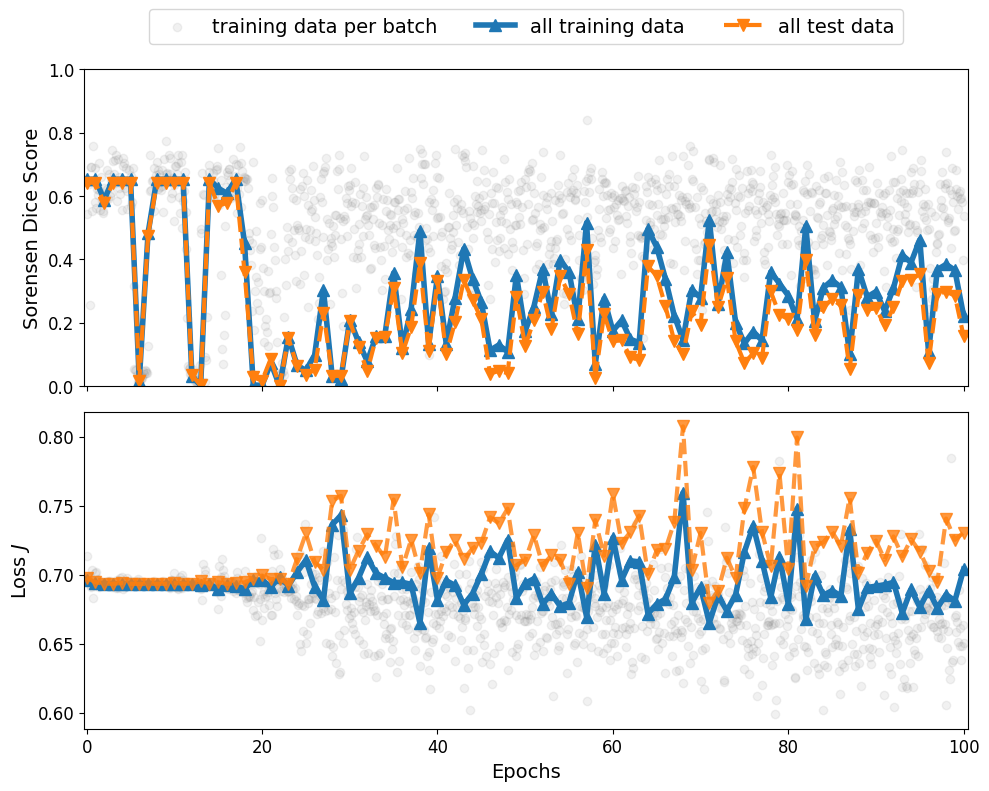

In [135]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

#### 2.2.3.1 Redesigning the network

In [ ]:
class NeuralNetworkWarwickDropoutBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwickDropoutBatchNorm, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.bn0 = nn.BatchNorm2d(2)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        x = self.bn0(x)
        x = self.downconv_0(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.bn1(x)
        x = self.downconv_1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.bn2(x)
        x = self.downconv_2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.bn3(x)
        x = self.downconv_3(x)
        x = self.relu(x)
        
        x = self.upconv_0(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.upconv_1(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.upconv_2(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        logits = self.output(x)        
        return logits


In [ ]:
fname = 'ex21_convnn_warwick_augmented_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww_augmented, lr_adam_ww_augmented, batch_size_train_ww_augmented)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropout()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_augmented)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww_augmented, dataloader_test_ww_augmented, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww_augmented)
    mynn.to_disk(fname)